# Implementation of LSTM autoencoder
cite https://arxiv.org/abs/1607.00148

In [17]:
import numpy as np 
import tensorflow as tf
from tensorflow.contrib import rnn
from util import ImShow as I
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict

In [18]:
class lstm_autoencoder(object):
    def __init__(**para):
        pass
    def fit(**para):
        pass

## Model test

(500, 784)
Counter({1: 66, 9: 55, 2: 52, 4: 52, 7: 52, 0: 50, 3: 50, 6: 45, 5: 39, 8: 39})


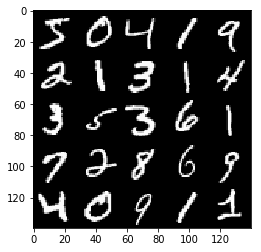

In [19]:
x = np.load("/home/zc8304/Documents/train_x_small.pkl")
y = np.load("/home/zc8304/Documents/train_y_small.pkl")
print x.shape
print Counter(y)
x_pic = I.tile_raster_images(X=x, img_shape=(28,28), tile_shape=(5,5))
plt.close('all')
plt.imshow(x_pic,cmap='gray')
plt.show()

(7, 784)
(7, 784)
(7, 784)
(7, 784)
(7, 784)
(7, 784)
(7, 784)
(7, 784)
(8, 7, 784)
(8, 784, 7)
(784, 7)


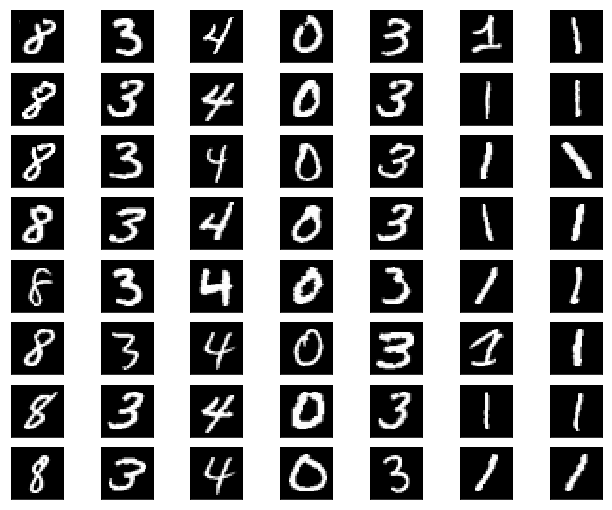

In [29]:
d = defaultdict(list)
for index,num in enumerate(y):
    d[num].append(index)
def gen_picseq(X,invind,seq=[8,3,4,0,3,1,1],seed=17):
    np.random.seed(seed)
    pic_seq = []
    for i in seq:
        pi = np.random.choice(d[i])
        pic_seq.append(X[pi])
    return pic_seq

pic_seqs = []
num = 8
for _ in range(8):
    pq = np.stack(gen_picseq(X=x,invind=d,seed=np.random.randint(65535)))
    print pq.shape
    pic_seqs.append(pq)
pic_seqs = np.stack(pic_seqs)
print pic_seqs.shape
pic_seqs = np.transpose(pic_seqs,axes=[0,2,1])
print pic_seqs.shape

pic_list = map(lambda x: x.reshape(784,7),np.split(pic_seqs,indices_or_sections=8,axis=0))
print pic_list[0].shape
# for i in range(7):
#     plt.imshow(pic_list[0][:,i].reshape(28,28),cmap='gray')
#     plt.show()
fig,ax = plt.subplots(ncols=7,nrows=8)
for i in range(8):
    for j in range(7):
        ax[i][j].imshow(pic_list[i][:,j].reshape(28,28),cmap='gray')
        ax[i][j].axes.get_yaxis().set_visible(False)
        ax[i][j].axes.get_xaxis().set_visible(False)
fig.set_size_inches(11,9)
plt.show()

In [37]:

print pic_seqs.shape

num = 8
time_step = 7
input_dim = 784
hidden_dim = 400
batch_size = num
with tf.Graph().as_default():
    with tf.Session() as sess:
        input_x = tf.placeholder(dtype = tf.float32, shape = [num,input_dim,time_step])
        encode_cell = rnn.BasicLSTMCell(hidden_dim)
        decode_cell = rnn.BasicLSTMCell(hidden_dim)
        en_state = encode_cell.zero_state(batch_size = batch_size, dtype = tf.float32)
        de_state = decode_cell.zero_state(batch_size = batch_size, dtype = tf.float32)
        en_out_list = []
        de_out_list = []
        init_max_value = np.sqrt(6. / (hidden_dim + input_dim))
        W = tf.Variable(tf.random_uniform([hidden_dim,input_dim],
                                         minval = np.negative(init_max_value),maxval = init_max_value,
                                          seed=20))
        b = tf.Variable(tf.random_uniform([input_dim],-0.1,0.1))
        for x in tf.unstack(input_x,axis=2):
            out,en_state = encode_cell(x,en_state)
            en_out_list.append(out)
        dec_inputs = [tf.zeros((input_x.shape[0],input_x.shape[1]), dtype=tf.float32) for _ in range(input_x.shape[2])]
        out,de_state = decode_cell(dec_inputs[0],en_state)
        de_out_list.append(out)
        for x in dec_inputs[1:]:
            out,de_state = decode_cell(x,de_state)
            de_out_list.append(out)
        de_out_list = de_out_list[::-1]
        de_out_list = map(lambda x: tf.matmul(x,W)+b,de_out_list)
        dec_outputs = tf.transpose(tf.stack(de_out_list),[1,2,0])
        cost = tf.reduce_mean(tf.square(input_x-dec_outputs))
        trainer = tf.train.AdamOptimizer().minimize(cost)
        sess.run(tf.global_variables_initializer())
        for i in xrange(400):
            sess.run(trainer,feed_dict={input_x:pic_seqs})
            if i % 20 == 0:
                print "itertation:",i," cost:",sess.run(cost,feed_dict={input_x:pic_seqs})
        recon = sess.run(dec_outputs,feed_dict={input_x:pic_seqs})
        print recon.shape

(8, 784, 7)
itertation: 0  cost: 0.1033829
itertation: 20  cost: 0.05442967
itertation: 40  cost: 0.045711007
itertation: 60  cost: 0.039288986
itertation: 80  cost: 0.028943134
itertation: 100  cost: 0.017334737
itertation: 120  cost: 0.008798945
itertation: 140  cost: 0.0038663917
itertation: 160  cost: 0.0014944476
itertation: 180  cost: 0.0006065207
itertation: 200  cost: 0.00026477463
itertation: 220  cost: 0.00017769827
itertation: 240  cost: 6.073991e-05
itertation: 260  cost: 2.9245452e-05
itertation: 280  cost: 1.4246651e-05
itertation: 300  cost: 8.728426e-06
itertation: 320  cost: 1.8566676e-05
itertation: 340  cost: 6.233881e-06
itertation: 360  cost: 1.6661609e-06
itertation: 380  cost: 9.2479604e-07
(8, 784, 7)


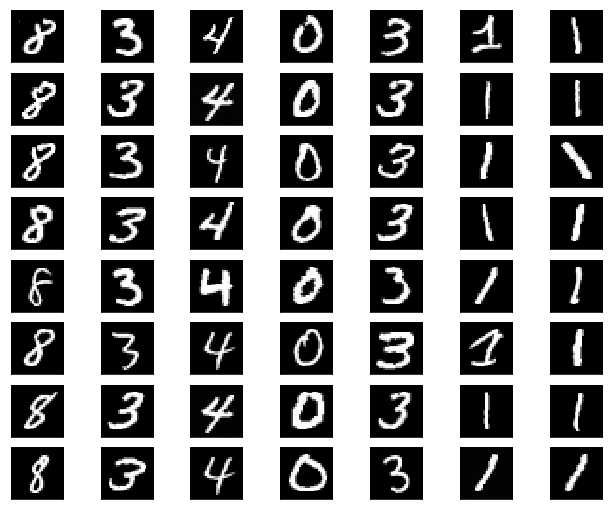

In [39]:
fig,ax = plt.subplots(ncols=7,nrows=8)
for i in range(8):
    for j in range(7):
        ax[i][j].imshow(recon[i,:,j].reshape(28,28),cmap='gray')
        ax[i][j].axes.get_yaxis().set_visible(False)
        ax[i][j].axes.get_xaxis().set_visible(False)
fig.set_size_inches(11,9)
plt.show()